### Imports

In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
%matplotlib inline

### Functions

In [49]:
def manual_ewm(df, alpha, result_col_name="Manual"):
    manual_ewma = []
    for x in df["Passengers"].to_numpy():
        if len(manual_ewma) > 0:
            xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
        else:
            xhat = x
        manual_ewma.append(xhat)
    df[result_col_name] = manual_ewma
    
def rmse(y, t):
    return np.sqrt(np.mean(y - t)**2)

def mae(y, t):
    return np.mean(np.abs(y- t))

### Code

In [3]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

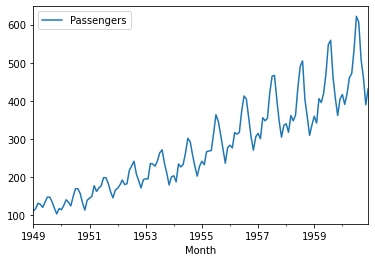

In [6]:
df.plot();

In [7]:
alpha = 0.2

In [8]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

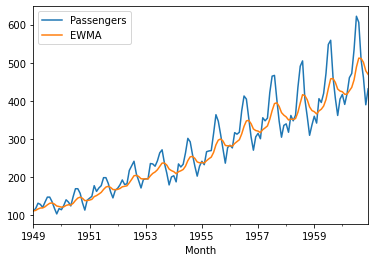

In [9]:
df.plot();

In [10]:
type(df["Passengers"].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [11]:
manual_ewm(df=df, alpha=alpha, result_col_name="Manual")

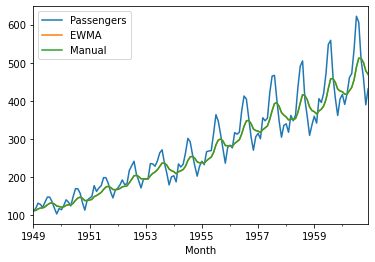

In [12]:
df.plot();

In [13]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
df.drop("Manual", axis=1, inplace=True)

In [15]:
ses = SimpleExpSmoothing(df["Passengers"])

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [16]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [17]:
df.index.freq = "MS"

In [18]:
ses = SimpleExpSmoothing(df["Passengers"])

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [19]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [20]:
res

In [21]:
res.predict(start=df.index[0], end=df.index[-1])

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [22]:
df["SES"] = res.predict(start=df.index[0], end=df.index[-1])

In [23]:
np.allclose(df["SES"], res.fittedvalues)

True

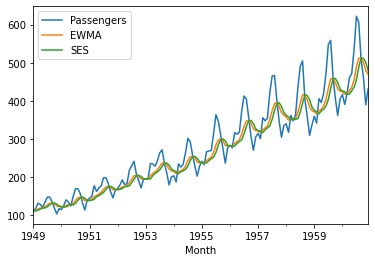

In [24]:
df.plot();

In [25]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [26]:
df["SES-1"] = df["SES"].shift(-1)

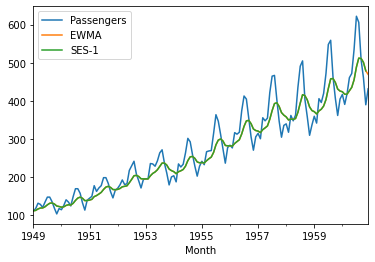

In [27]:
df[["Passengers","EWMA","SES-1"]].plot();

In [28]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [29]:
ses = SimpleExpSmoothing(train["Passengers"])
res = ses.fit()

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [30]:
# train_idx = df.index <= train.index[-1]
# test_idx = df.index > train.index[-1]

In [31]:
# df.loc[train_idx, 'SESfitted'] = res.fittedvalues
# df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
# df[['Passengers', 'SESfitted']].plot();

In [32]:
df.loc[:-N_test,"SESfitted"] = res.fittedvalues
df.loc[-N_test:,"SESfitted"] = res.forecast(N_test)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


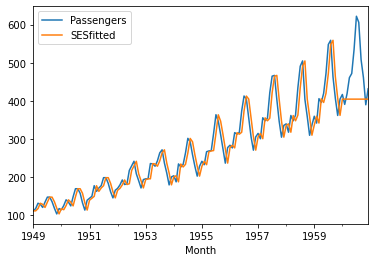

In [33]:
df[["Passengers","SESfitted"]].plot();

In [34]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt

In [35]:
holt = Holt(df["Passengers"])

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [36]:
res_h = holt.fit()

In [37]:
df["Holt"] = res_h.fittedvalues

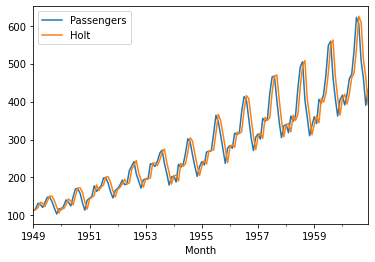

In [38]:
df[["Passengers", "Holt"]].plot();

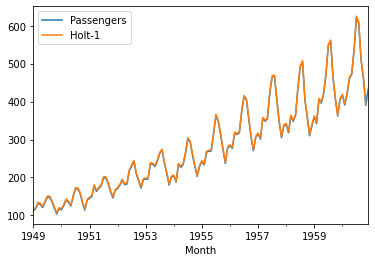

In [39]:
df["Holt-1"] = df["Holt"].shift(-1)
df[["Passengers", "Holt-1"]].plot();

In [40]:
holt = Holt(train["Passengers"])
res_h = holt.fit()
df.loc[:-N_test, "Holt"] = res_h.fittedvalues
df.loc[-N_test:, "Holt"] = res_h.forecast(N_test)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


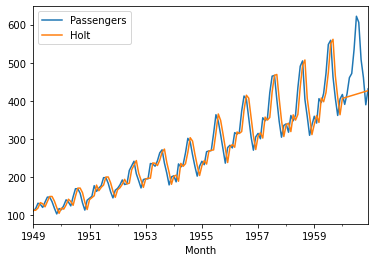

In [41]:
df[["Passengers", "Holt"]].plot();

### HoltWinters

In [63]:
hw = ExponentialSmoothing(train["Passengers"], trend="add", seasonal="add", seasonal_periods=12)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [64]:
res_hw = hw.fit()

In [65]:
df.loc[:-N_test, "HoltWinters"] = res_hw.fittedvalues
df.loc[-N_test:, "HoltWinters"] = res_hw.forecast(N_test)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


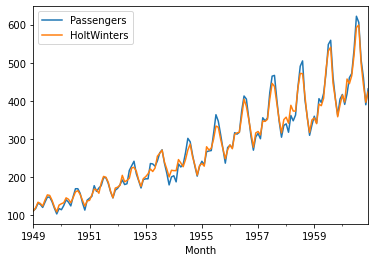

In [66]:
df[["Passengers", "HoltWinters"]].plot();

In [67]:
print("Train RMSE:", rmse(train["Passengers"], res_hw.fittedvalues))
print("Test RMSE:", rmse(test["Passengers"], res_hw.forecast(N_test)))

Train RMSE: 0.00011284552695527013
Test RMSE: 4.869023544912011


C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [68]:
print("Train MAE:", mae(train["Passengers"], res_hw.fittedvalues))
print("Test MAE:", mae(test["Passengers"], res_hw.forecast(N_test)))

Train MAE: 9.007632761638554
Test MAE: 13.38090260033752


In [69]:
hw = ExponentialSmoothing(train["Passengers"], trend="add", seasonal="mul", seasonal_periods=12)

res_hw = hw.fit()

df.loc[:-N_test, "HoltWinters"] = res_hw.fittedvalues
df.loc[-N_test:, "HoltWinters"] = res_hw.forecast(N_test)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


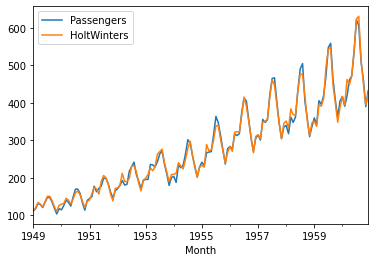

In [70]:
df[["Passengers", "HoltWinters"]].plot();

In [71]:
print("Train RMSE:", rmse(train["Passengers"], res_hw.fittedvalues))
print("Test RMSE:", rmse(test["Passengers"], res_hw.forecast(N_test)))

Train RMSE: 0.08104250675303022
Test RMSE: 4.78340375325925


C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [72]:
print("Train MAE:", mae(train["Passengers"], res_hw.fittedvalues))
print("Test MAE:", mae(test["Passengers"], res_hw.forecast(N_test)))

Train MAE: 7.604248661578993
Test MAE: 10.303168417106946


In [73]:
hw = ExponentialSmoothing(train["Passengers"], trend="mul", seasonal="mul", seasonal_periods=12)

res_hw = hw.fit()

df.loc[:-N_test, "HoltWinters"] = res_hw.fittedvalues
df.loc[-N_test:, "HoltWinters"] = res_hw.forecast(N_test)

C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


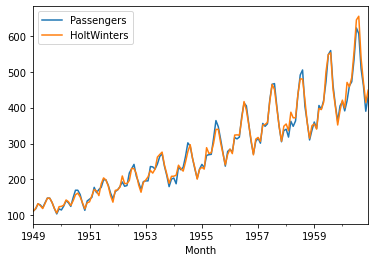

In [74]:
df[["Passengers", "HoltWinters"]].plot();

In [75]:
print("Train RMSE:", rmse(train["Passengers"], res_hw.fittedvalues))
print("Test RMSE:", rmse(test["Passengers"], res_hw.forecast(N_test)))

Train RMSE: 0.0066806759287698705
Test RMSE: 20.387815509761527


C:\Users\Tohid\anaconda\envs\pattern7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [76]:
print("Train MAE:", mae(train["Passengers"], res_hw.fittedvalues))
print("Test MAE:", mae(test["Passengers"], res_hw.forecast(N_test)))

Train MAE: 7.112308480047951
Test MAE: 20.845533012201845
